# Individual Contributions of each Fmap to Loss

In [1]:
from utils.results import *
import torch
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
import ipywidgets as widgets

In [2]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'scratch','squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'combined','contamination', 'crack', 'faulty_imprint', 'pill_type','scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck','thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil','rough'],
    'toothbrush': ['defective'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'combined','fabric_border', 'fabric_interior','split_teeth','rough', 'squeezed_teeth']
}

# Bottle

In [3]:

# settings for the plots,
dataset= 'mvtec'
run= "contamination_0"  
experiment=  "DEV_refinement_25_03_24_1-"#,"Exp0-r18",
category= "bottle"


RESPATH="results"
DATASET=os.path.join(RESPATH, dataset)  
RUN_PATH= os.path.join(RESPATH, dataset,run)

# trainingfmap
TRAINSAVE_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "trainsave_ind_loss.pth")
train_scores_individual = torch.load(TRAINSAVE_PATH)

# training loss
TRAINSAVE_1_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "trainsave_loss_orig.pth")
train_scores_orig = torch.load(TRAINSAVE_1_PATH)

# test fmap
TESTSAVE_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_ind_loss.pth")
test_scores_individual = torch.load(TESTSAVE_PATH)

# testsave afer interpolation
TESTSAVE_2_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_loss_orig.pth")
test_scores_orig = torch.load(TESTSAVE_2_PATH)

TESTSAVE_3_PATH = os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_score_after_interpolation.pth")
test_scores_interpolation = torch.load(TESTSAVE_3_PATH)


TESTSAVE_4_PATH = os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_score_end.pth")
test_scores_end = torch.load(TESTSAVE_4_PATH)


### Trainset

#### sample per fmap
y axis : sample losses

x axis : featuremaps

In [4]:
def heatmaps_per_epoch(epoch):
    firsthmap=[]
    for key in train_scores_individual.keys():
        firsthmap.append(train_scores_individual[key][epoch])
        
    stacked_tensor = torch.stack(firsthmap, dim=0)
    # Plotting the heatmap
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.05)  # Set vmin and vmax for colorbar range
    plt.colorbar()  # Show the color bar representing the value scale
    plt.xlabel('Fmap')
    plt.ylabel('sample')
    plt.title(f'Training, Images vs Features Individual losses, category: {category}')
    plt.show()
epoch_slider = widgets.IntSlider(value=0,min=0,max=50-1,step=1,description='Epoch:')
widgets.interact(heatmaps_per_epoch, epoch=epoch_slider)

interactive(children=(IntSlider(value=0, description='Epoch:', max=49), Output()), _dom_classes=('widget-inter…

<function __main__.heatmaps_per_epoch(epoch)>

#### sample loss per epoch
the loss considered by the model from each sample

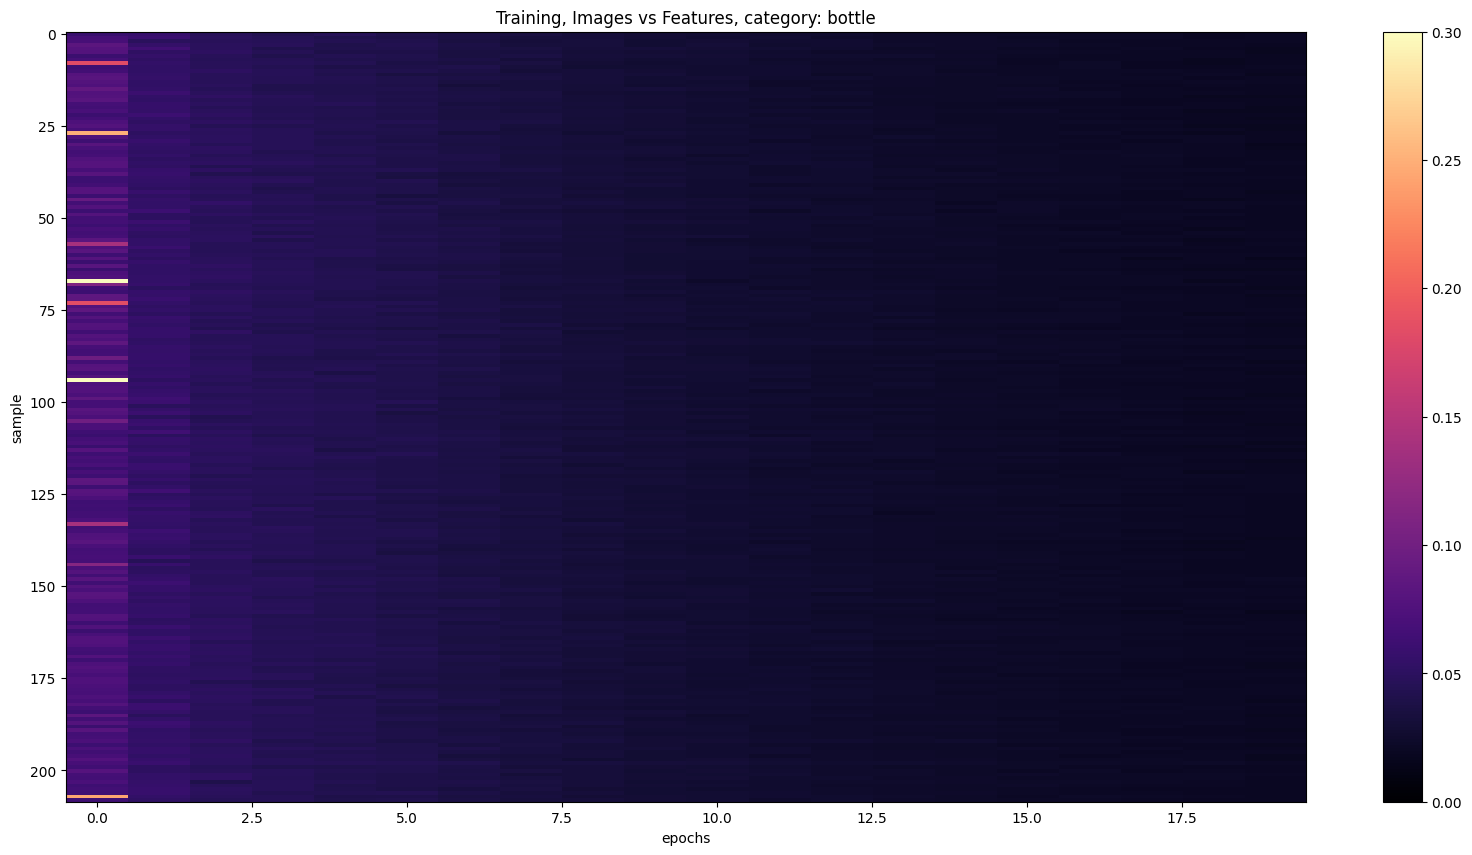

In [5]:
hmap = []
for key in train_scores_orig.keys():
    if isinstance(train_scores_orig[key], list) and all(isinstance(t, torch.Tensor) for t in train_scores_orig[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in train_scores_orig[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(train_scores_orig[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.3)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'Training, Images vs Features, category: {category}')
plt.show()


### Testset 


#### sample per fmap

In [6]:
color_map = {
    'good': [0, 1, 0],  # Red
    'broken_large': [1, 0, 0],  # Green
    'broken_small': [0, 0, 1], # Blue
    'contamination': [1, 1, 0], # Yellow
}

anolist=anomaly_categories[category].copy()
anolist.append('good')

index_dict={}
for ano_category in anolist:
    index_dict[ano_category] = [index for index, item in enumerate(list(test_scores_individual.keys())  ) if ano_category in item]
    
color_data = np.zeros((len(test_scores_individual), 5,3))

for anocat in anolist:
    color_data[index_dict[anocat], :, :] = color_map[anocat]
    

In [7]:
def heatmaps_test_per_epoch(epoch):
    firsthmap = []
    for key in test_scores_individual.keys():
        firsthmap.append(test_scores_individual[key][epoch])

    stacked_tensor = torch.stack(firsthmap, dim=0)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(21, 10), gridspec_kw={'width_ratios': [1, 20]})

    # Plot the color plot on the left
    axs[0].imshow(color_data, aspect='auto')
    
    axs[0].axis('off')  # Hide the axis on the color plot

    # Plot the heatmap to the right
    im = axs[1].imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.05)
    fig.colorbar(im, ax=axs[1])  # Show the color bar representing the value scale
    axs[1].set_xlabel('Fmap')
    axs[1].set_title(f'test, Images vs Features: {category}')

    plt.tight_layout()
    plt.show()
widgets.interact(heatmaps_test_per_epoch, epoch=epoch_slider)

interactive(children=(IntSlider(value=0, description='Epoch:', max=49), Output()), _dom_classes=('widget-inter…

<function __main__.heatmaps_test_per_epoch(epoch)>

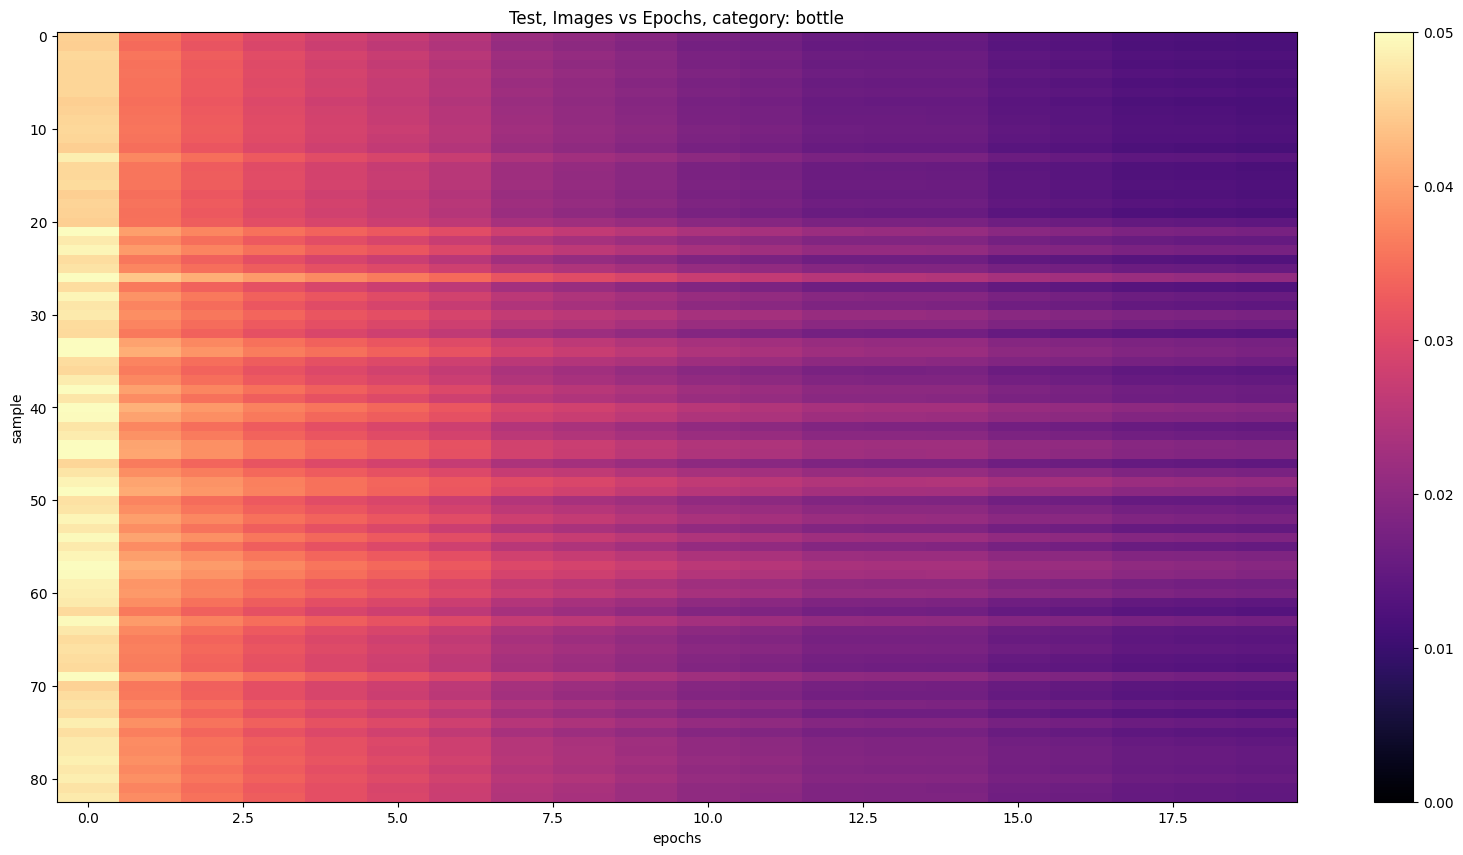

In [8]:
hmap = []
for key in test_scores_orig.keys():
    if isinstance(test_scores_orig[key], list) and all(isinstance(t, torch.Tensor) for t in test_scores_orig[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in test_scores_orig[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(test_scores_orig[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.05)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'Test, Images vs Epochs, category: {category}')
plt.show()


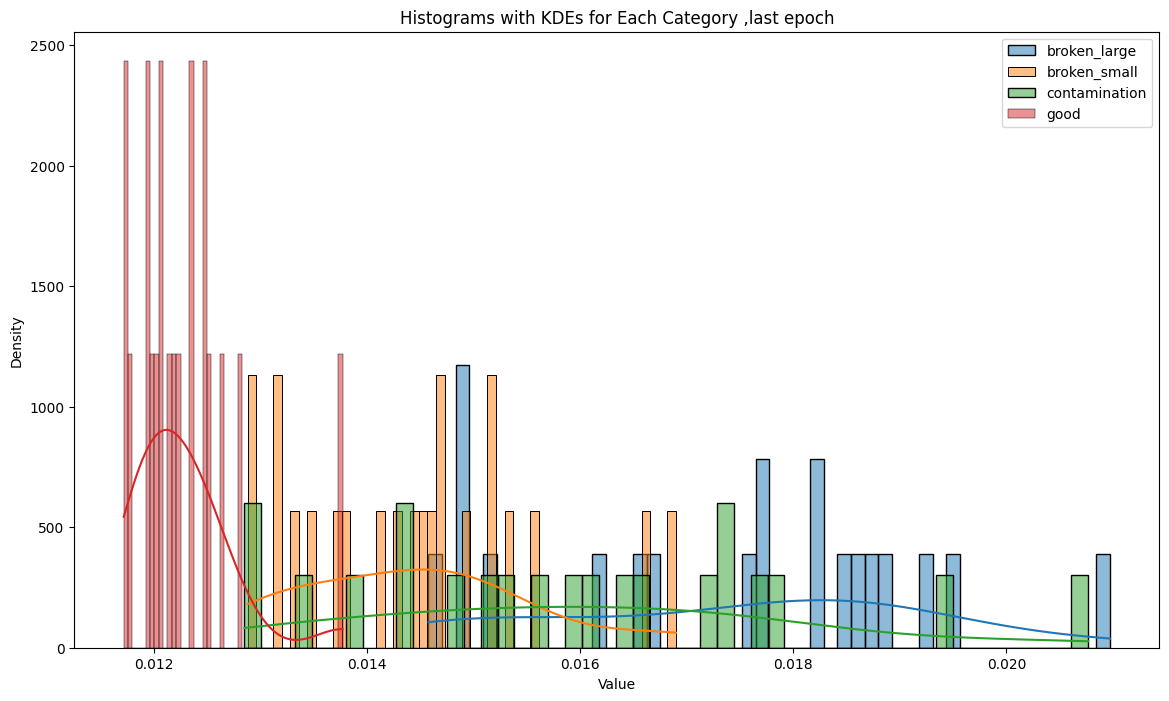

In [9]:
firsthmap = []
for key in test_scores_interpolation.keys():
    firsthmap.append(test_scores_orig[key][-1])
stacked_tensor = torch.stack(firsthmap, dim=0)
plt.figure(figsize=(14, 8))
for key, indices in index_dict.items():
    sns.histplot(stacked_tensor[indices], kde=True, label=key, stat='density',bins=50)
plt.legend()
plt.title('Histograms with KDEs for Each Category ,last epoch')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

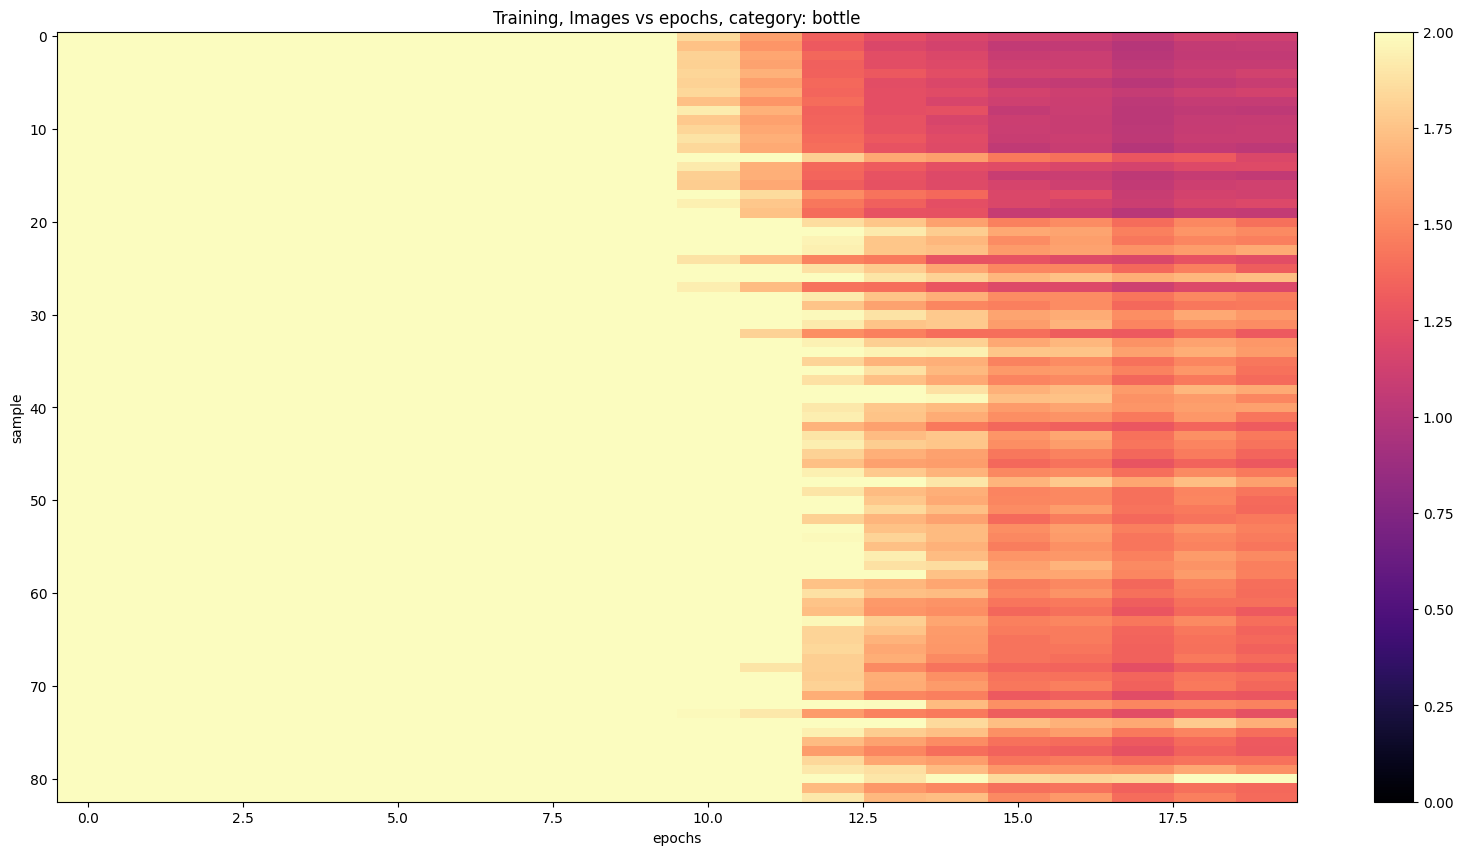

In [10]:
hmap = []
for key in test_scores_interpolation.keys():
    if isinstance(test_scores_interpolation[key], list) and all(isinstance(t, torch.Tensor) for t in test_scores_interpolation[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in test_scores_interpolation[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(test_scores_interpolation[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=2)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'Training, Images vs epochs, category: {category}')
plt.show()


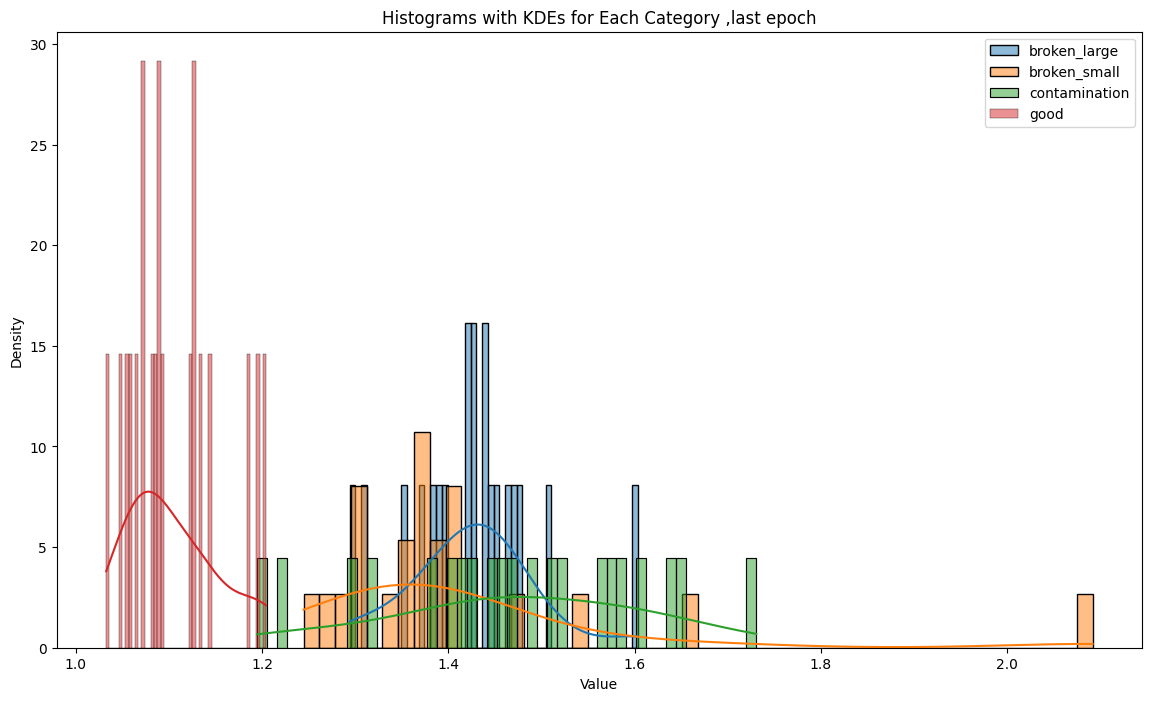

In [11]:
firsthmap = []
for key in test_scores_interpolation.keys():
    firsthmap.append(test_scores_interpolation[key][-1])
stacked_tensor = torch.stack(firsthmap, dim=0)
plt.figure(figsize=(14, 8))
for key, indices in index_dict.items():
    sns.histplot(stacked_tensor[indices], kde=True, label=key, stat='density',bins=50)
plt.legend()
plt.title('Histograms with KDEs for Each Category ,last epoch')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

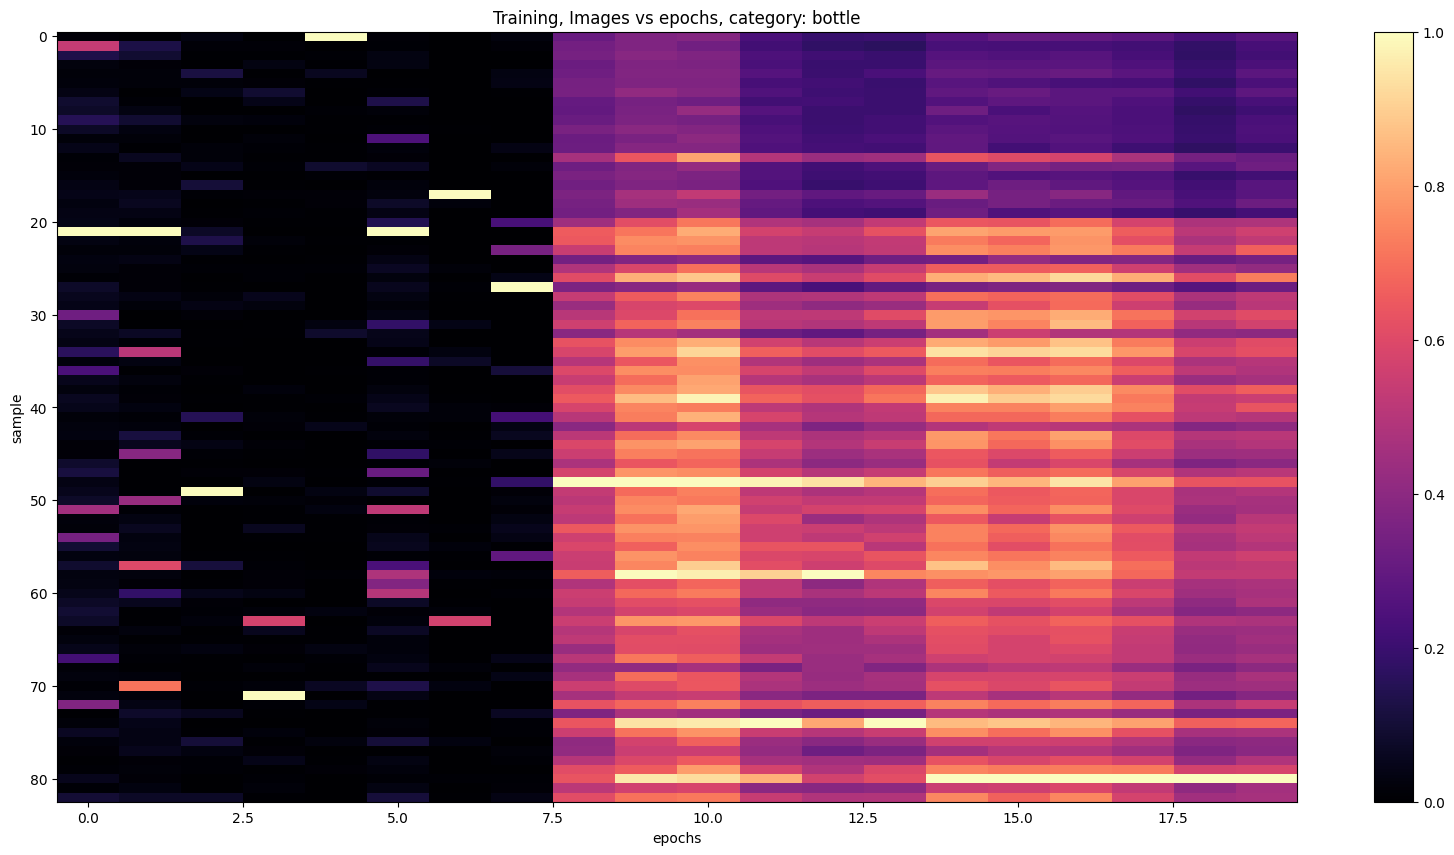

In [12]:
hmap = []
for key in test_scores_end.keys():
    if isinstance(test_scores_end[key], list) and all(isinstance(t, torch.Tensor) for t in test_scores_end[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in test_scores_end[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(test_scores_end[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=1)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'Training, Images vs epochs, category: {category}')
plt.show()

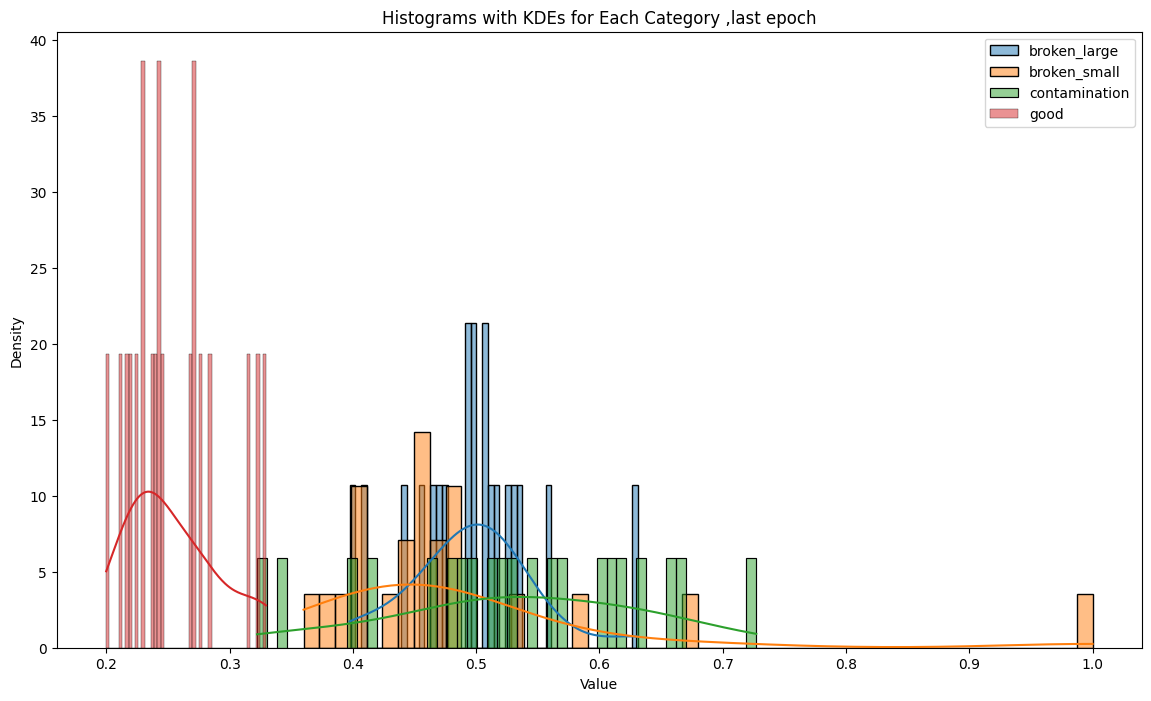

In [13]:
firsthmap = []
for key in test_scores_end.keys():
    firsthmap.append(test_scores_end[key][-1])
stacked_tensor = torch.stack(firsthmap, dim=0)
plt.figure(figsize=(14, 8))
for key, indices in index_dict.items():
    sns.histplot(stacked_tensor[indices], kde=True, label=key, stat='density',bins=50)
plt.legend()
plt.title('Histograms with KDEs for Each Category ,last epoch')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## ---------------------------------------------------------------------------------------------------------------------
## Screw

In [14]:
# settings for the plots,
dataset= 'mvtec'
run= "contamination_0"  
experiment=  "DEV_refinement_25_03_24_1-"#,"Exp0-r18",
category= "screw"


RESPATH="results"
DATASET=os.path.join(RESPATH, dataset)  
RUN_PATH= os.path.join(RESPATH, dataset,run)

# trainingfmap
TRAINSAVE_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "trainsave_ind_loss.pth")
train_scores_individual = torch.load(TRAINSAVE_PATH)

# training loss
TRAINSAVE_1_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "trainsave_loss_orig.pth")
train_scores_orig = torch.load(TRAINSAVE_1_PATH)

# test fmap
TESTSAVE_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_ind_loss.pth")
test_scores_individual = torch.load(TESTSAVE_PATH)

# testsave afer interpolation
TESTSAVE_2_PATH= os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_loss_orig.pth")
test_scores_orig = torch.load(TESTSAVE_2_PATH)

TESTSAVE_3_PATH = os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_score_after_interpolation.pth")
test_scores_interpolation = torch.load(TESTSAVE_3_PATH)


TESTSAVE_4_PATH = os.path.join(RUN_PATH, experiment+ f'{category}', "testsave_score_end.pth")
test_scores_end = torch.load(TESTSAVE_4_PATH)

In [15]:
def heatmaps_per_epoch(epoch):
    firsthmap=[]
    for key in train_scores_individual.keys():
        firsthmap.append(train_scores_individual[key][epoch])
        
    stacked_tensor = torch.stack(firsthmap, dim=0)
    # Plotting the heatmap
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.5)  # Set vmin and vmax for colorbar range
    plt.colorbar()  # Show the color bar representing the value scale
    plt.xlabel('Fmap')
    plt.title('Training, Images vs Features')
    plt.show()
epoch_slider = widgets.IntSlider(value=0,min=0,max=100-1,step=1,description='Epoch:')
widgets.interact(heatmaps_per_epoch, epoch=epoch_slider)

interactive(children=(IntSlider(value=0, description='Epoch:', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.heatmaps_per_epoch(epoch)>

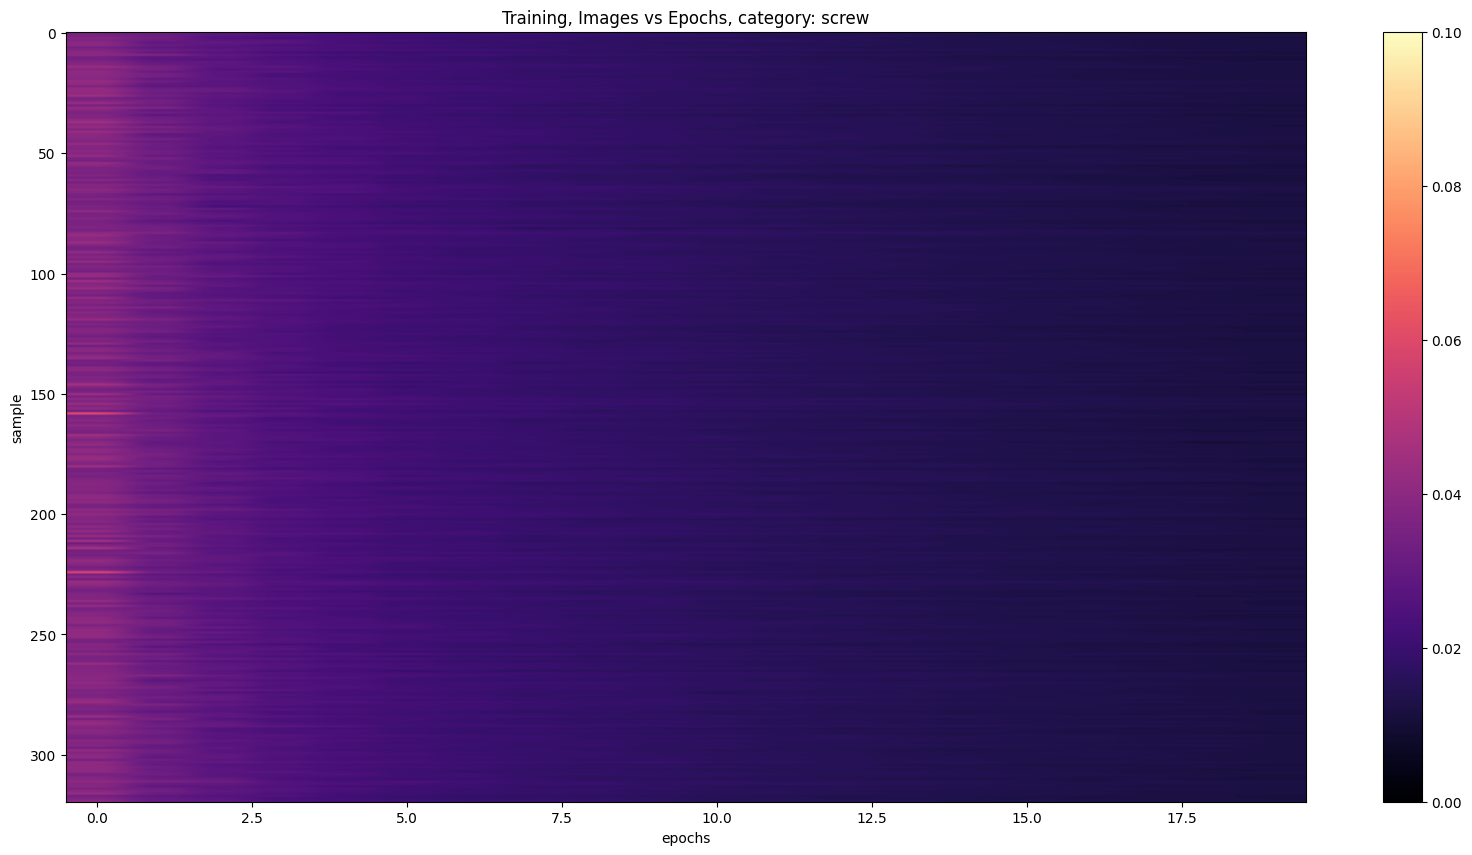

In [16]:
hmap = []
for key in train_scores_orig.keys():
    if isinstance(train_scores_orig[key], list) and all(isinstance(t, torch.Tensor) for t in train_scores_orig[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in train_scores_orig[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(train_scores_orig[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.1)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'Training, Images vs Epochs, category: {category}')
plt.show()


In [17]:
color_map = {
    'good': [0, 1, 0],  # Red
    'manipulated_front': [1, 0, 0],  # Green
    'scratch_head': [0, 0, 1], # Blue
    'scratch_neck': [1, 1, 0], # Yellow
    'thread_side': [0, 1, 1],
    'thread_top': [1, 0, 1],
}

anolist=anomaly_categories[category].copy()
anolist.append('good')

index_dict={}
for ano_category in anolist:
    index_dict[ano_category] = [index for index, item in enumerate(list(test_scores_individual.keys())  ) if ano_category in item]
    
color_data = np.zeros((len(test_scores_individual), 5,3))

for anocat in anolist:
    color_data[index_dict[anocat], :, :] = color_map[anocat]
    

In [18]:
def heatmaps_test_per_epoch(epoch):
    firsthmap = []
    for key in test_scores_individual.keys():
        firsthmap.append(test_scores_individual[key][epoch])

    stacked_tensor = torch.stack(firsthmap, dim=0)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(21, 10), gridspec_kw={'width_ratios': [1, 20]})

    # Plot the color plot on the left
    axs[0].imshow(color_data, aspect='auto')
    
    axs[0].axis('off')  # Hide the axis on the color plot

    # Plot the heatmap to the right
    im = axs[1].imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.03)
    fig.colorbar(im, ax=axs[1])  # Show the color bar representing the value scale
    axs[1].set_xlabel('Fmap')
    axs[1].set_title(f'test, Images vs Features: {category}')

    plt.tight_layout()
    plt.show()
widgets.interact(heatmaps_test_per_epoch, epoch=epoch_slider)

interactive(children=(IntSlider(value=0, description='Epoch:', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.heatmaps_test_per_epoch(epoch)>

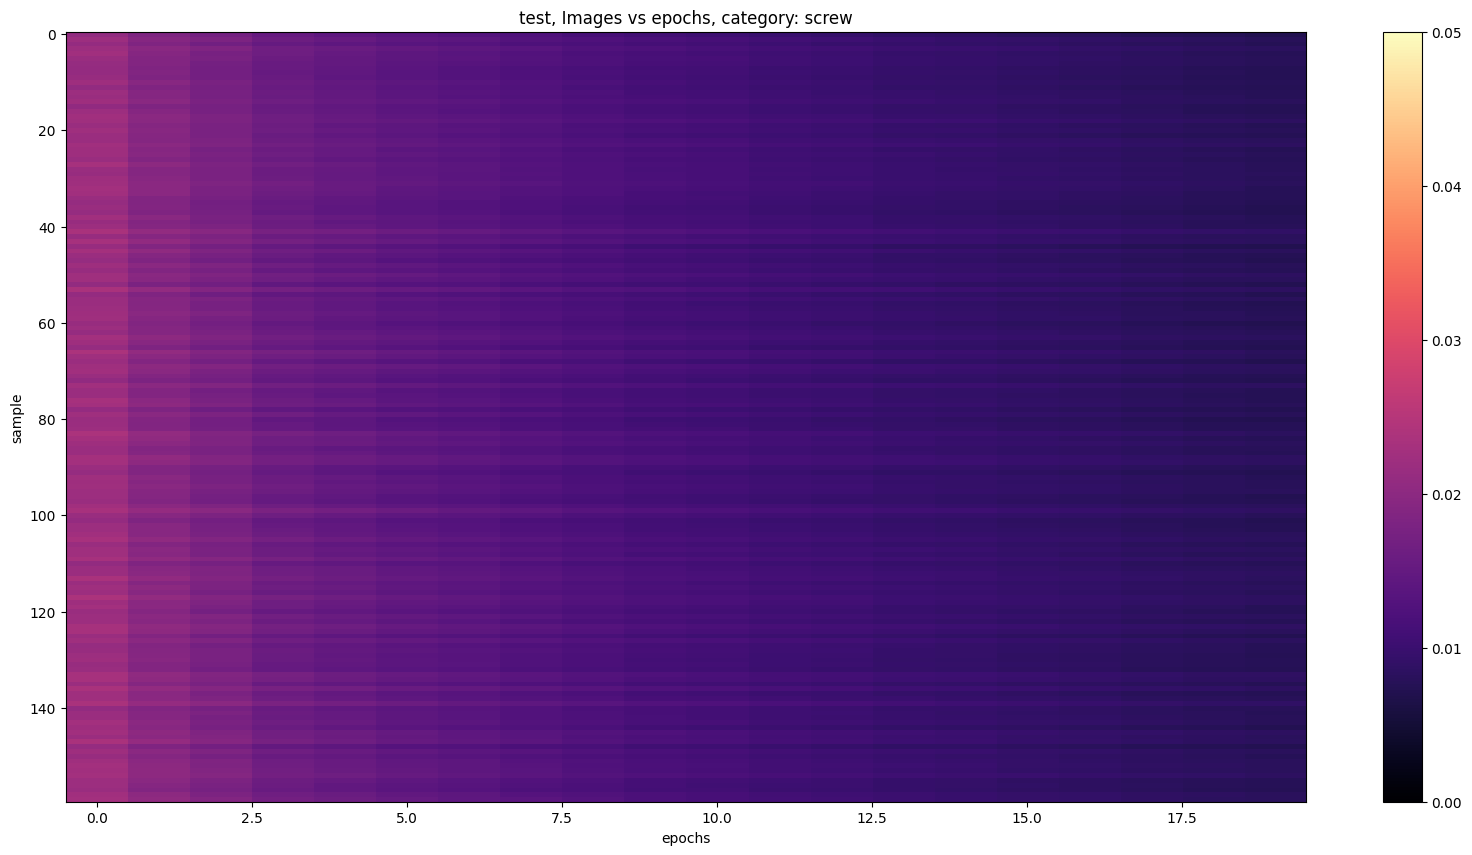

In [19]:
hmap = []
for key in test_scores_orig.keys():
    if isinstance(test_scores_orig[key], list) and all(isinstance(t, torch.Tensor) for t in test_scores_orig[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in test_scores_orig[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(test_scores_orig[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=0.05)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'test, Images vs epochs, category: {category}')
plt.show()


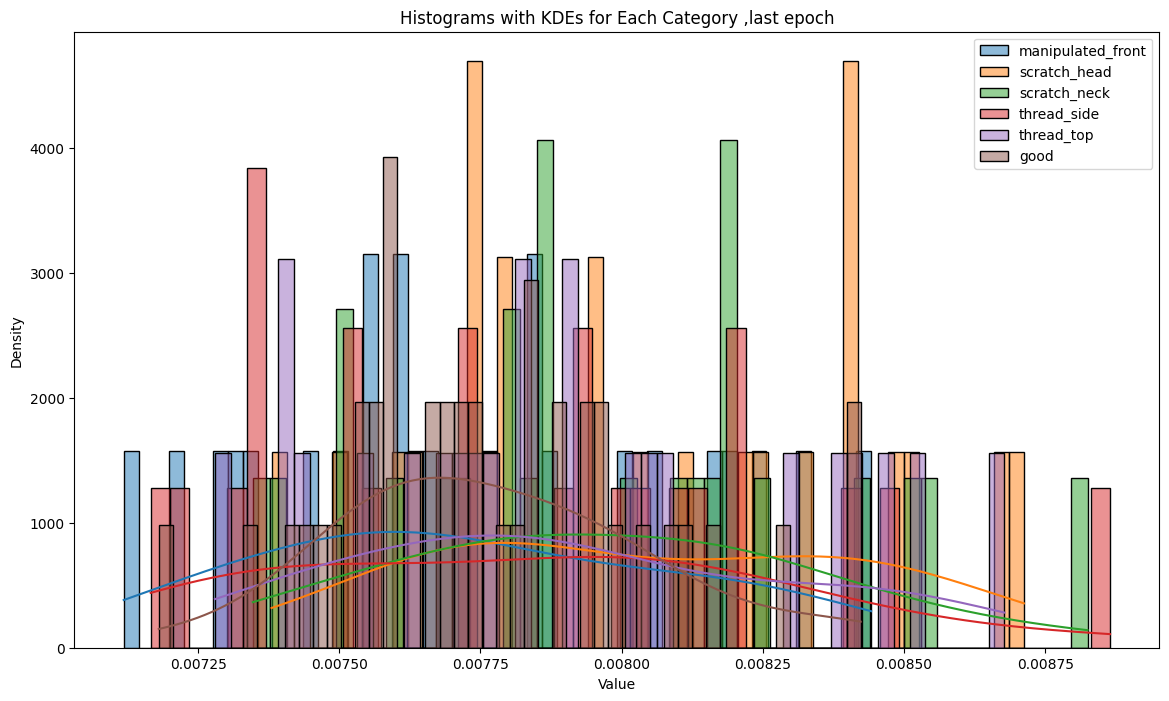

In [20]:
firsthmap = []
for key in test_scores_orig.keys():
    firsthmap.append(test_scores_orig[key][-1])
stacked_tensor = torch.stack(firsthmap, dim=0)
plt.figure(figsize=(14, 8))
for key, indices in index_dict.items():
    sns.histplot(stacked_tensor[indices], kde=True, label=key, stat='density',bins=50)
plt.legend()
plt.title('Histograms with KDEs for Each Category ,last epoch')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

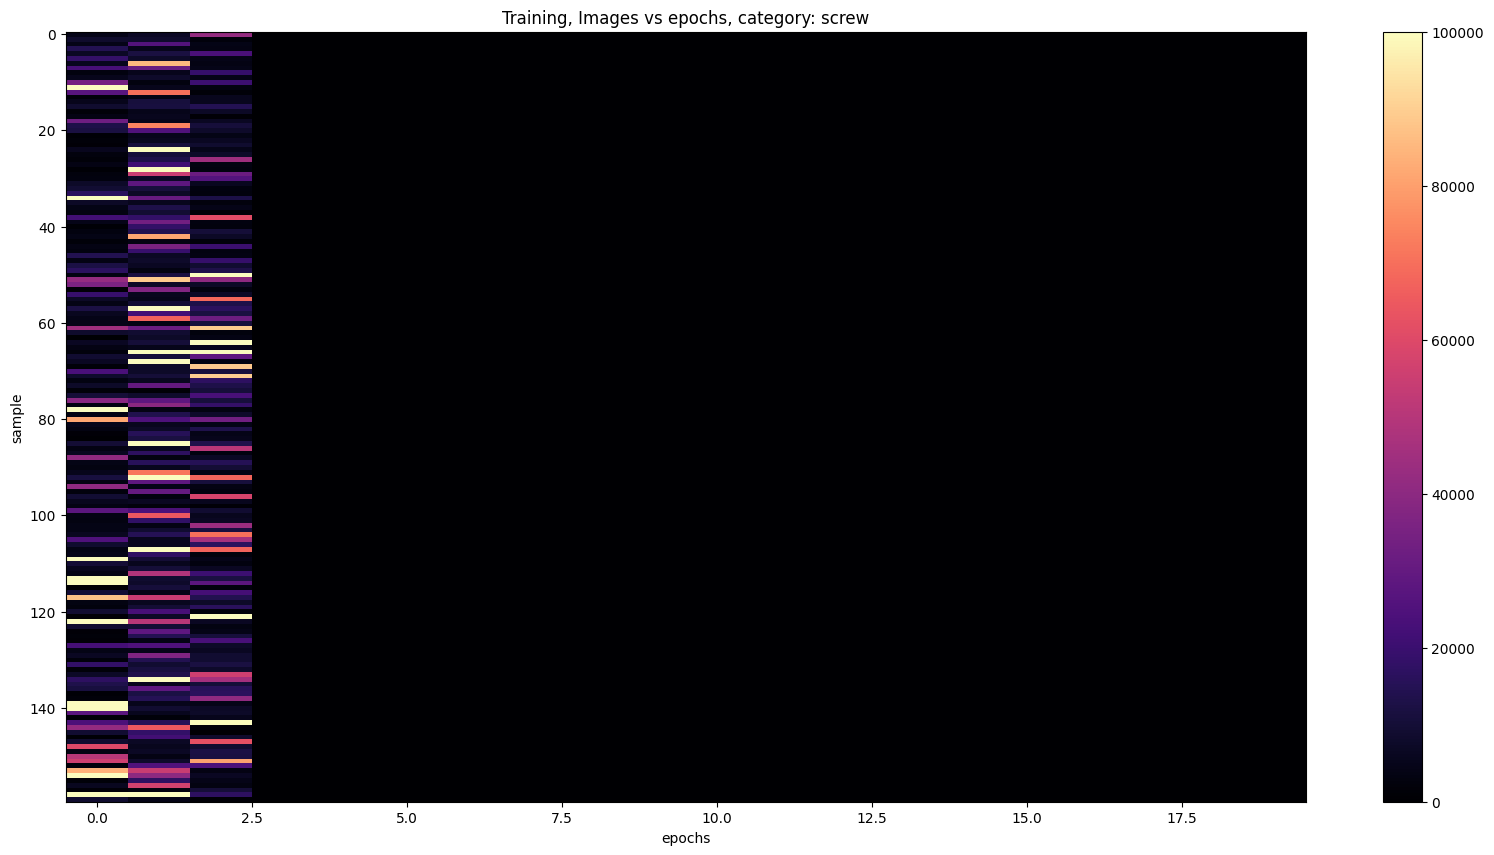

In [21]:
hmap = []
for key in test_scores_interpolation.keys():
    if isinstance(test_scores_interpolation[key], list) and all(isinstance(t, torch.Tensor) for t in test_scores_interpolation[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in test_scores_interpolation[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(test_scores_interpolation[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=100_000)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'Training, Images vs epochs, category: {category}')
plt.show()


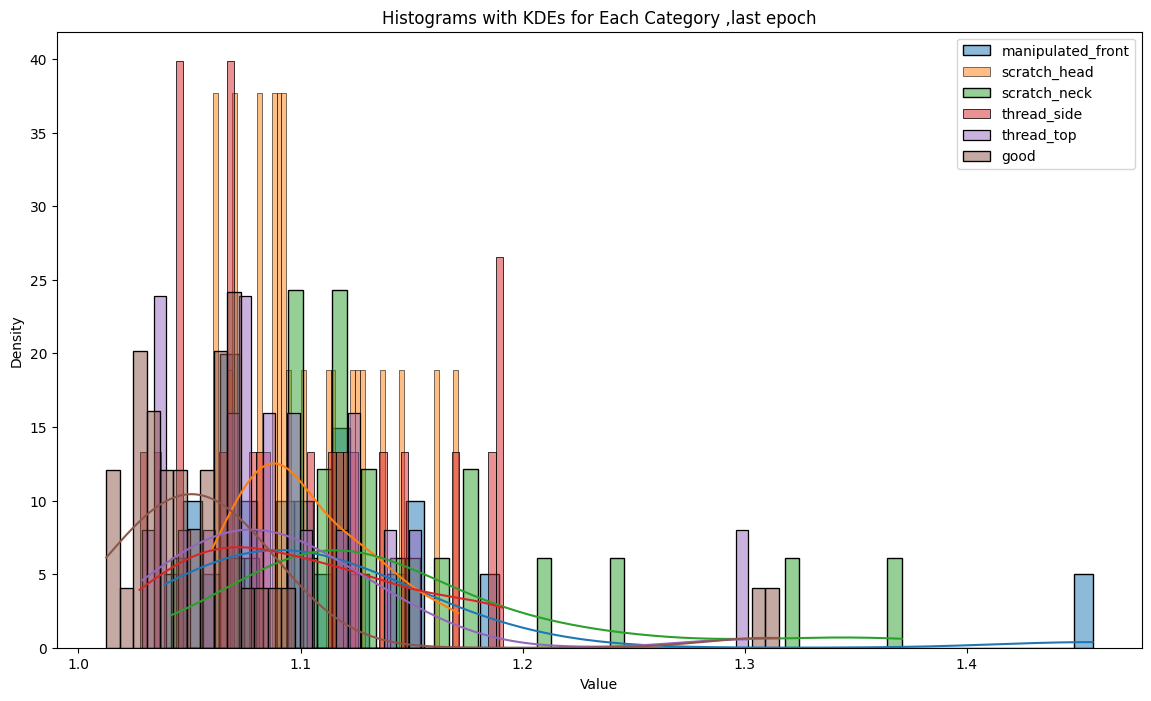

In [22]:
firsthmap = []
for key in test_scores_interpolation.keys():
    firsthmap.append(test_scores_interpolation[key][-1])
stacked_tensor = torch.stack(firsthmap, dim=0)
plt.figure(figsize=(14, 8))
for key, indices in index_dict.items():
    sns.histplot(stacked_tensor[indices], kde=True, label=key, stat='density',bins=50)
plt.legend()
plt.title('Histograms with KDEs for Each Category ,last epoch')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

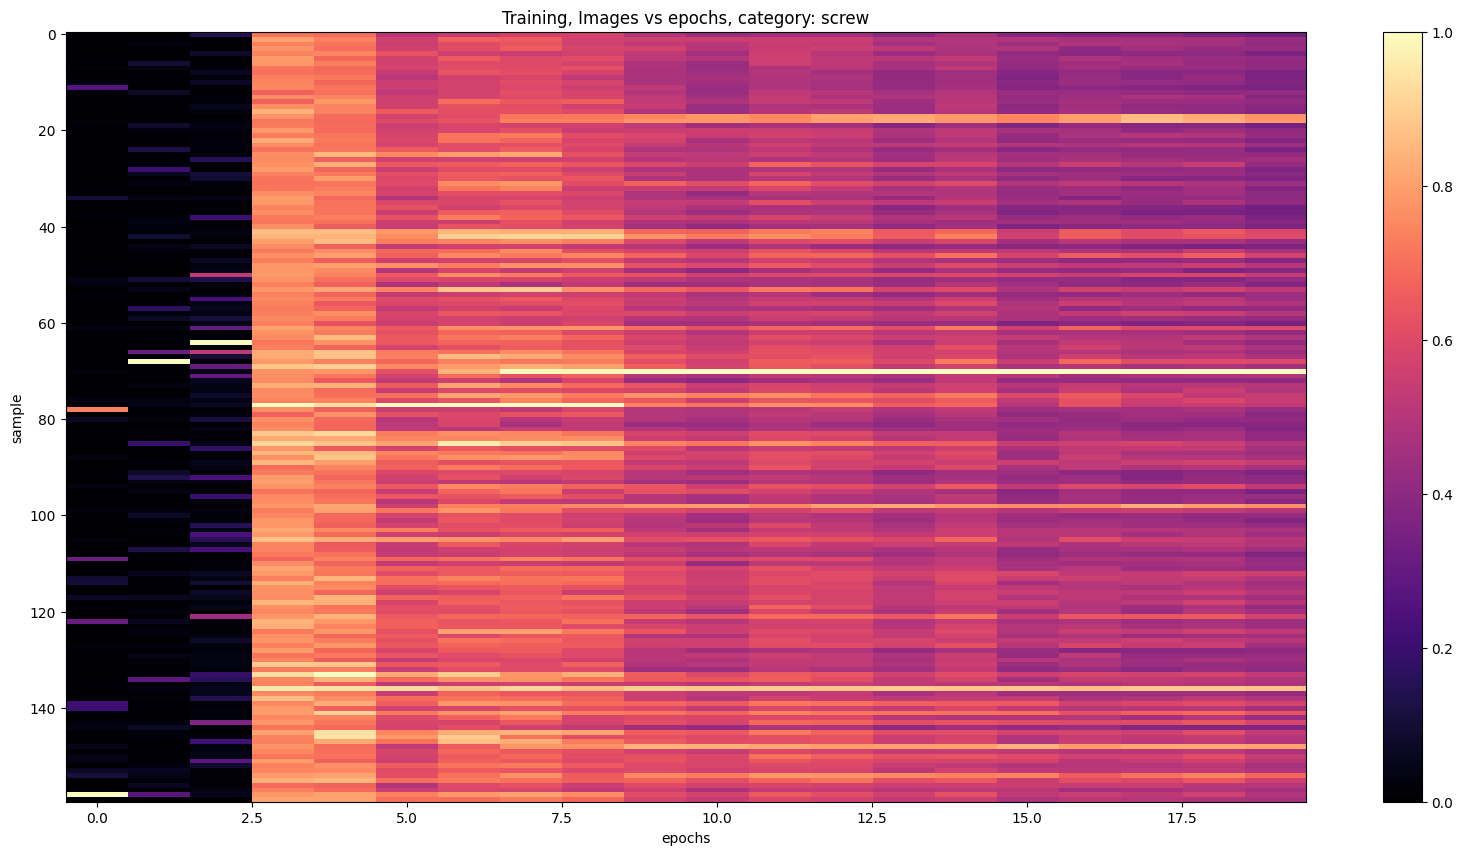

In [23]:
hmap = []
for key in test_scores_end.keys():
    if isinstance(test_scores_end[key], list) and all(isinstance(t, torch.Tensor) for t in test_scores_end[key]):
        tensor = torch.cat([t.unsqueeze(0) for t in test_scores_end[key]], dim=0)
        hmap.append(tensor)
    else:
        hmap.append(test_scores_end[key])
stacked_tensor = torch.stack(hmap, dim=0)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(stacked_tensor, aspect='auto', cmap='magma', vmin=0, vmax=1)  # Set vmin and vmax for colorbar range
plt.colorbar()  # Show the color bar representing the value scale
plt.xlabel('epochs')
plt.ylabel('sample')
plt.title(f'Training, Images vs epochs, category: {category}')
plt.show()


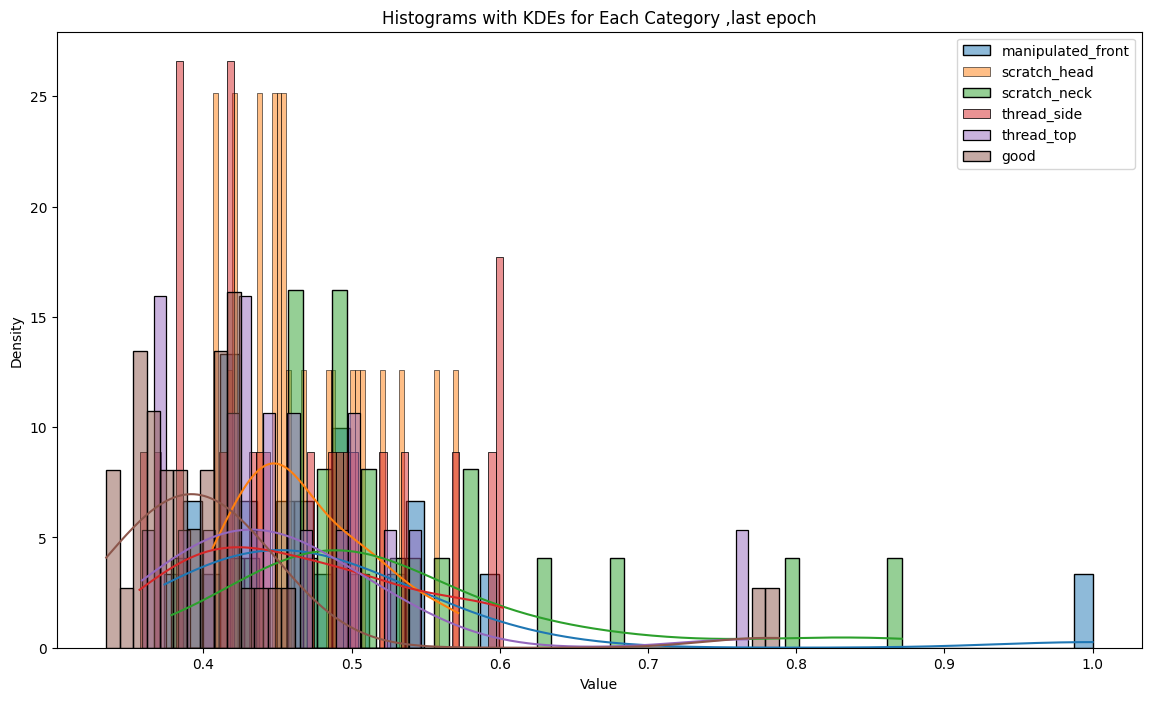

In [24]:
firsthmap = []
for key in test_scores_end.keys():
    firsthmap.append(test_scores_end[key][-1])
stacked_tensor = torch.stack(firsthmap, dim=0)
plt.figure(figsize=(14, 8))
for key, indices in index_dict.items():
    sns.histplot(stacked_tensor[indices], kde=True, label=key, stat='density',bins=50)
plt.legend()
plt.title('Histograms with KDEs for Each Category ,last epoch')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()